In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import spatial
from sklearn.metrics import r2_score
import sys

sys.path.append('..')
from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from parameter_choosing import *
from performance_metrics import *

# Load Data

In [3]:
def set_smallest_eigenvalue_real_part(A,lam):

    #lam is the desired maximum eigenvalue
    assert lam < 0, print('Eigenvalue must be negative')

    #get current eigenvalues
    e,v = np.linalg.eig(A)
    largest_eig = np.max(np.real(e))
    I = np.eye(len(e))
  
    #return scaled 
    return A - largest_eig*I + lam*I

def do_one_sde_run(n, lam_awake, lam_anesthesia, awake = 1):

    np.random.seed(42)

    A = np.random.normal(0,1/np.sqrt(n),(n,n))

    if awake == 1:
        #pick the stability parameter
        lam = lam_awake

        # Define the Weiner process    
        dW = np.sqrt(dt) * np.random.randn(N,n)

        #define systems matrix
        A_awake = set_smallest_eigenvalue_real_part(A,lam)

    else:

        lam = lam_anesthesia

        dW = np.sqrt(dt) * np.random.randn(N,n)

        A_anesthesia = set_smallest_eigenvalue_real_part(A,lam)


    # Define the function f(x)
    def f(x,lam):
        if awake == 1:
            return A_awake @ x
        else:
            return A_anesthesia @ x


    # Define the function g(x)
    def g(x):
        return 1

    # Initialize the x array
    x = np.zeros((N,n))
    x[0] = np.zeros(n)

    # Simulate the stochastic differential equation
    for i in range(1, N):
        x[i] = x[i-1] + f(x[i-1],lam) * dt + g(x[i-1]) * dW[i]

    return x

In [4]:
# Define the parameters
# N = int(1e5)
N = 20000
n = 100
T = 40.0
dt = T / N
x0 = 0.0

In [5]:
# #try two different lambdas
# lam_1, lam_2 = -1e0, -1e-2
# x_1 = do_one_sde_run(n, lam_awake = lam_1, lam_anesthesia = lam_2, awake = 1)
# x_2 = do_one_sde_run(n, lam_awake = lam_1, lam_anesthesia = lam_2, awake = 0)

# # Plot the results
# plt.plot(np.linspace(0, T, N), x_1[:,0], label = f'$\lambda_1(A) = {lam_1}$')
# plt.plot(np.linspace(0, T, N), x_2[:,0], label = f'$\lambda_1(A) = {lam_2}$')

# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('x[0]')
# plt.title('Noisy Linear Filter $\dot{x} = Ax + w(t)$')

# plt.show()

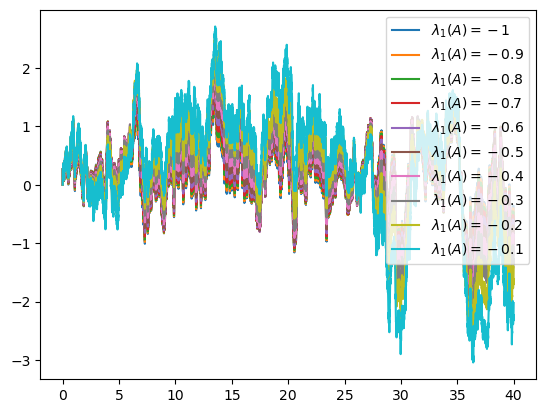

In [6]:
lams = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1]
trajs = {}
for lam in lams:
    x_1 = do_one_sde_run(n, lam_awake = lam, lam_anesthesia = 0, awake = 1)
    trajs[lam] = x_1
    plt.plot(np.linspace(0, T, N), x_1[:,0], label = f'$\lambda_1(A) = {lam}$')
plt.legend()
plt.show()

# Grid Search

In [9]:
num_samples = 10
indices = np.random.choice(np.arange(n), num_samples, replace=False)

In [291]:
# parameter_grid = ParameterGrid(
#     window_vals=np.array([15000]),
#     matrix_size_vals=np.array([6400]),
#     r_thresh_vals=np.array([0, 1e-5, 1e-3, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 3, 5, 10]),
#     lamb_vals=np.array([0, 1e-12, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 1.5, 2, 3, 5, 10, 50, 100]),
#     reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
# )
parameter_grid = ParameterGrid(
    window_vals=np.array([10000]),
    matrix_size_vals=np.array([20, 50, 100, 200, 300, 500, 750, 1000]),
    reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
)
exp_variance_vals = np.array([0.8, 0.85, 0.9, 0.95, 0.97, 0.98, 0.99, 0.999, 0.9999])

In [292]:
def compute_explained_variance(S):
    return torch.cumsum(S**2/((S**2).sum()), 0)

prediction_time = 3000
transient = 2000

In [293]:
# results = []
# iterator = tqdm(total=len(parameter_grid.window_vals)*len(parameter_grid.matrix_size_vals)*len(exp_variance_vals))
# for window in parameter_grid.window_vals:
#     for matrix_size in parameter_grid.matrix_size_vals:
#         delases = []
#         exp_variances = []
#         test_signals = []
#         for key, signal in trajs.items():
#             train_signal = signal[transient:transient + window, indices]
#             test_signal = signal[transient + window:transient + window + prediction_time, indices]
#             delase = DeLASE(train_signal, matrix_size=matrix_size, dt=dt, use_torch=True, device='cuda')
       
#             exp_variances.append(compute_explained_variance(delase.S.cpu()))
#             delases.append(delase)
#             test_signals.append(test_signal)
            
#         for thresh in exp_variance_vals:
#             r = np.max([int(np.argmax(exp_variance > thresh)) for exp_variance in exp_variances])
            
#             ips = []
#             stab_curves = []
#             for i, delase in enumerate(delases):
#                 delase.compute_havok_dmd(r=r)
#                 delase.get_stability(max_freq=500, max_unstable_freq=125)
            
#                 ip = compute_integrated_performance(delase, test_signals[i], full_return=True)
                
#                 ips.append(ip)
#                 stab_curves.append(delase.stability_params.cpu())
            
#             results.append(dict(
#                 window=window,
#                 matrix_size=matrix_size,
#                 exp_variances=exp_variances,
#                 exp_variance_thresh=thresh,
#                 r=r,
#                 ips=ips,
#                 stab_curves=stab_curves,
#             ))
            
#             pd.to_pickle(results, os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'results_linear_models_r_comparison.pkl'))
            
#             iterator.update()
# iterator.close()

In [294]:
results = pd.DataFrame(pd.read_pickle(os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'results_linear_models_r_comparison.pkl')))

In [295]:
results['ip_mean'] = results.ips.apply(lambda x: np.mean([ip['ip'] for ip in x]))

In [296]:
matrix_size_vals = parameter_grid.matrix_size_vals
exp_variance_thresh_vals = exp_variance_vals

In [297]:
top_percent = 0.1

In [298]:
ip_mean = np.zeros((len(matrix_size_vals), len(exp_variance_thresh_vals)))
stab_curve = {}
# wake_stab = {}
# anesthesia_stab = {}
for i, matrix_size in enumerate(matrix_size_vals):
    for j, exp_variance_thresh in enumerate(exp_variance_thresh_vals):
        row = results[np.logical_and(results.matrix_size == matrix_size, results.exp_variance_thresh == exp_variance_thresh)].iloc[0]
        ip_mean[i, j] = row.ip_mean
        stab_curve[(matrix_size, exp_variance_thresh)] = np.array([curve[:int(top_percent*len(curve))].mean() for curve in row.stab_curves])
#         wake_stab[(matrix_size, exp_variance_thresh)] = row.stab_wake.cpu()
#         anesthesia_stab[(matrix_size, exp_variance_thresh)] = row.stab_anesthesia.cpu()

In [299]:
ip_mean

array([[0.58301487, 0.77668824, 0.77269243, 0.75970633, 0.77889621,
        0.77889621, 0.77889621, 0.81612344, 0.81198254],
       [0.56099664, 0.76939463, 0.76840794, 0.74435894, 0.75984357,
        0.75984357, 0.75984357, 0.81413969, 0.80876554],
       [0.5699522 , 0.77080538, 0.77257045, 0.74241638, 0.75406438,
        0.75406438, 0.75406438, 0.81560217, 0.81644919],
       [0.58032007, 0.76548975, 0.76961264, 0.73335088, 0.74735001,
        0.74735001, 0.70439704, 0.82975785, 0.83016053],
       [0.59748682, 0.75717429, 0.76292693, 0.74798999, 0.74798999,
        0.74147275, 0.48507774, 0.82208763, 0.8198408 ],
       [0.70614059, 0.71817759, 0.71069068, 0.72508766, 0.48545567,
        0.32607454, 0.74314156, 0.80412234, 0.80464883],
       [0.63073713, 0.6395129 , 0.66253668, 0.49469947, 0.49722784,
        0.69131079, 0.47790138, 0.79891299, 0.79859514],
       [0.63420056, 0.64022462, 0.65377036, 0.60065819, 0.50834279,
        0.54584909, 0.7510533 , 0.840325  , 0.84317414]])

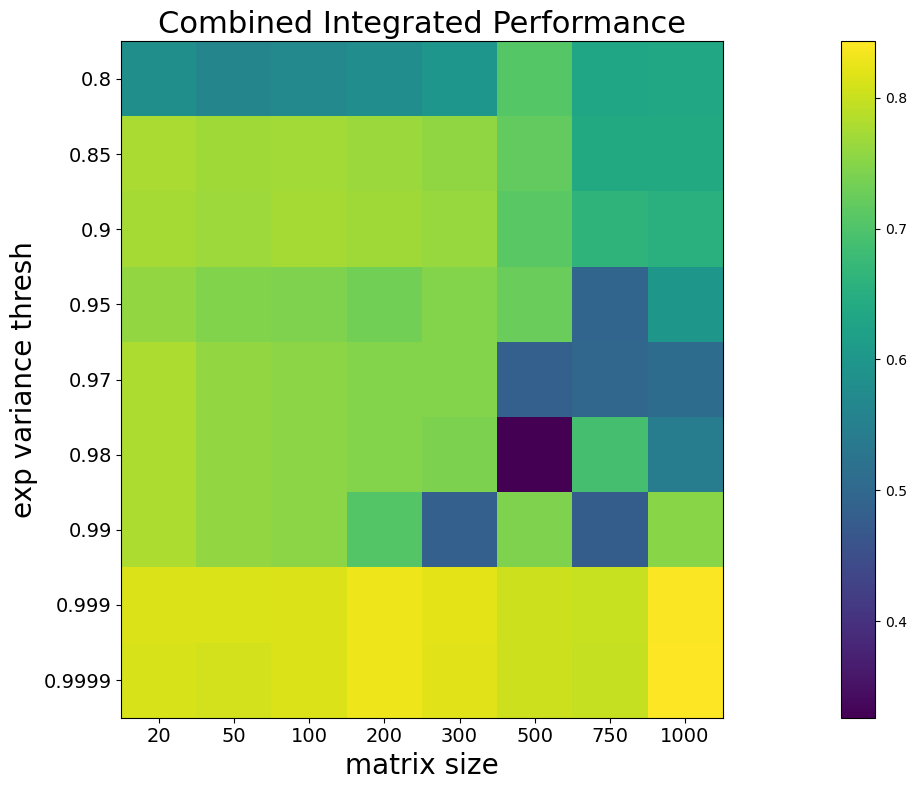

In [300]:
plt.figure(figsize=(24, 8))

norm = Normalize(vmin=ip_mean.min(),vmax=ip_mean.max())

plt.imshow(ip_mean.T, norm=norm)
plt.xticks(np.arange(len(matrix_size_vals)), [f"{matrix_size}" for matrix_size in matrix_size_vals])
plt.xlabel("matrix size", fontsize=20)
plt.yticks(np.arange(len(exp_variance_thresh_vals)), [f"{exp_variance_thresh}" for exp_variance_thresh in exp_variance_thresh_vals])
plt.ylabel('exp variance thresh', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=14)
ax.set_title('Combined Integrated Performance', fontsize=22)
plt.colorbar(ax=ax)

plt.tight_layout()
plt.show()

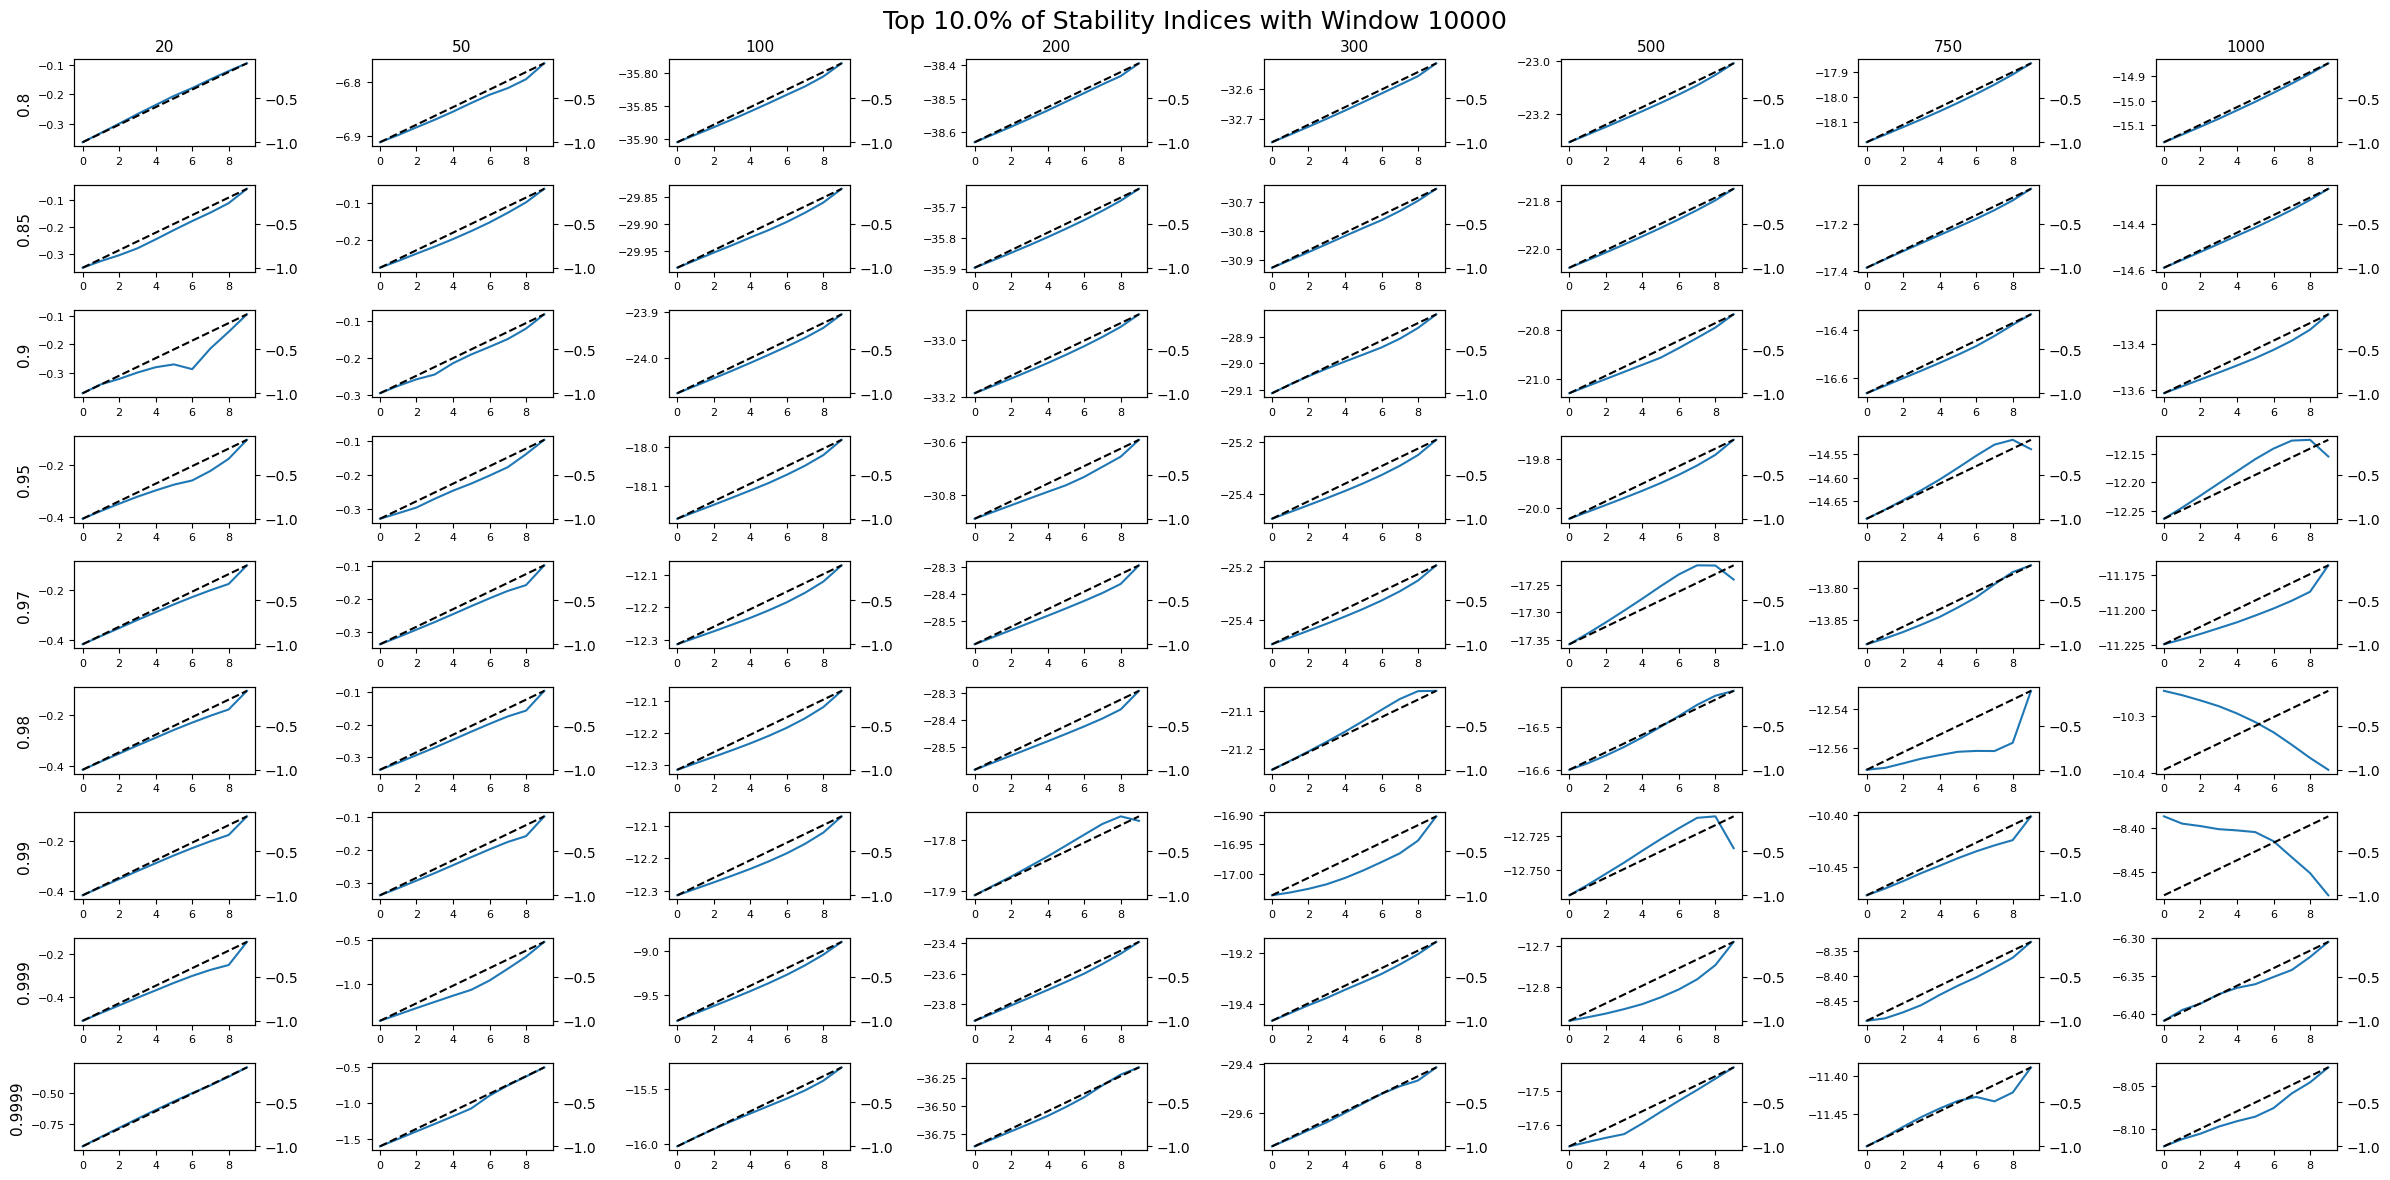

In [301]:
fig, axs = plt.subplots(len(exp_variance_thresh_vals), len(matrix_size_vals), figsize=(24, 12))
for i, exp_variance_thresh in enumerate(exp_variance_thresh_vals):
    for j, matrix_size in enumerate(matrix_size_vals):
        ax = axs[i][j]
        ax.plot(stab_curve[(matrix_size, exp_variance_thresh)])
        ax2 = ax.twinx()
        ax2.plot(lams, linestyle='--', c='k')
        if i == 0:
            ax.set_title(f'{matrix_size}', fontsize=11)
        if j == 0:
            ax.set_ylabel(f'{exp_variance_thresh}', fontsize=11)
        ax.tick_params(labelsize=8)
plt.suptitle(f'Top {top_percent*100}% of Stability Indices with Window {window}', fontsize=18)
plt.tight_layout()
plt.show()

## False Nearest Neighbours

In [311]:
def get_nn_indices(pts, time_step_bound=10, sample_indices=None, p=2):
    if sample_indices is None:
        sample_indices = np.arange(pts.shape[0] - 1)
    kdTree = spatial.cKDTree(pts[:-1])
    nn_dist, nn_inds = kdTree.query(embedding[sample_indices], k=2*time_step_bound + 1, p=p)
    nn_indices = np.zeros(nn_inds.shape[0], dtype=int)
    nn_distances = np.zeros(nn_dist.shape[0])
    for i in range(nn_indices.shape[0]):
        nn_num = np.argmax(np.abs(nn_inds[i] - sample_indices[i]) >= time_step_bound)
        nn_indices[i] = nn_inds[i][nn_num]
        nn_distances[i] = nn_dist[i][nn_num]
    return nn_indices, nn_distances, sample_indices

def get_metric(p, name=False):
    if p == 1:
        if name:
            return "cityblock"
        return spatial.distance.cityblock
    elif p == 2:
        if name:
            return "euclidean"
        return spatial.distance.euclidean
    elif p == np.Inf:
        if name:
            return "chebyshev"
        return spatial.distance.chebyshev
    else:
        if name:
            return "minkowski"
        return lambda u, v: spatial.distance.minkowski(u, v, p=p)

def calculate_fnn_stat(pts, nn_indices, r, sample_indices=None, p=2, verbose=True):
    if sample_indices is None:
        sample_indices = np.arange(pts.shape[0])
    
    metric = get_metric(p)

    N = pts.shape[0]
    nn_distances = []
    nn_next_step_distances = []

    for ind in tqdm(range(len(sample_indices)), disable=not verbose):
        i = sample_indices[ind]
        j = nn_indices[ind]
        if i + 1 < N and j + 1 < N:
            nn_distance = metric(pts[i], pts[j])
            if nn_distance == 0:
                nn_distances.append(1)
                nn_next_step_distances.append(np.Inf)
            else:
                nn_distances.append(nn_distance)
                nn_next_step_distances.append(metric(pts[i + 1], pts[j + 1]))
    nn_distances, nn_next_step_distances = np.array(nn_distances), np.array(nn_next_step_distances)
    ratios = nn_next_step_distances / nn_distances
    fraction_greater = np.sum(ratios > r) / len(ratios)
    return fraction_greater, ratios

In [312]:
m_vals = np.array([int(np.ceil(matrix_size/10)) for matrix_size in matrix_size_vals])
# m_vals = np.hstack([1, m_vals])
# m_vals = np.arange(10) + 1
fraction_fnn = np.zeros(m_vals.shape)

In [313]:
m_vals

array([  2,   5,  10,  20,  30,  50,  75, 100])

In [314]:
trajs.keys()

dict_keys([-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1])

In [315]:
num_samples = 1000
time_step_bound = 10
r=1.0616
p = 2
iterator = tqdm(total=len(trajs)*len(m_vals))
ratio_arrays_all = np.zeros((len(trajs), len(m_vals), num_samples))
for i, (key, signal) in enumerate(trajs.items()):
    
    fnn_stats = []
    ratio_arrays = []
    for j, m in enumerate(m_vals):
        embedding = embed_signal((signal - signal.mean())/signal.std(), m, tau=1)
        sample_indices = np.random.choice(np.arange(embedding.shape[0] - 1), size=(num_samples, ), replace=False)
        nn_indices, _, sample_indices = get_nn_indices(embedding, time_step_bound, sample_indices, p=p)
        fraction_greater, ratios = calculate_fnn_stat(embedding, nn_indices, r, sample_indices=sample_indices, p=p, verbose=False)
#         fnn_stats.append(fraction_greater)
#         ratio_arrays.append(ratios)
        ratio_arrays_all[i, j] = ratios
        
        iterator.update()
    
#     min_length = np.min([len(ratio) for ratio in ratio_arrays])
#     ratio_arrays = np.array([ratio[:min_length] for ratio in ratio_arrays])
iterator.close()

  0%|          | 0/80 [00:00<?, ?it/s]

In [316]:
((ratio_arrays_all > 1.0616).sum(axis=(0, 2))/(ratio_arrays_all.shape[0]*ratio_arrays_all.shape[2])).astype(float)

array([0.0339, 0.001 , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ])

# Chaotic Nets

In [198]:
chaotic_net_path = "/scratch2/weka/millerlab/eisenaj/DynamicalTrajectories/chaotic_net_data"

W = pd.read_pickle(os.path.join(chaotic_net_path, "W.pkl"))
lyaps = pd.read_pickle(os.path.join(chaotic_net_path, "lyaps_long.pkl"))
full_signals = pd.read_pickle(os.path.join(chaotic_net_path, "chaotic_net_signals_long.pkl"))

In [199]:
N = list(full_signals.values())[0].shape[2]
T = list(full_signals.values())[0].shape[1]
dt = 0.01

In [200]:
noise_sd = 0.1
# noise_sd = 0
normalize = False
# indices = np.random.choice(np. arange(N), size=(50,), replace=False)
indices = pd.read_pickle(os.path.join(chaotic_net_path, "indices.pkl"))
signals = {}
for key in full_signals.keys():
    signals[key] = full_signals[key][0][:, indices] 
    if normalize:
        signals[key] = (signals[key] - signals[key].mean())/signals[key].std()
    signals[key] += np.random.randn(T, len(indices))*noise_sd

In [211]:
# parameter_grid = ParameterGrid(
#     window_vals=np.array([15000]),
#     matrix_size_vals=np.array([6400]),
#     r_thresh_vals=np.array([0, 1e-5, 1e-3, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 3, 5, 10]),
#     lamb_vals=np.array([0, 1e-12, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 1.5, 2, 3, 5, 10, 50, 100]),
#     reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
# )
parameter_grid = ParameterGrid(
    window_vals=np.array([10000]),
    matrix_size_vals=np.array([50, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000]),
    reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
)
exp_variance_vals = np.array([0.8, 0.85, 0.9, 0.95, 0.97, 0.98, 0.99, 0.999, 0.9999])

In [201]:
def compute_explained_variance(S):
    return torch.cumsum(S**2/((S**2).sum()), 0)

prediction_time = 4000
transient = 2000

In [202]:
results = []
iterator = tqdm(total=len(parameter_grid.window_vals)*len(parameter_grid.matrix_size_vals)*len(exp_variance_vals))
for window in parameter_grid.window_vals:
    for matrix_size in parameter_grid.matrix_size_vals:
        delases = []
        exp_variances = []
        test_signals = []
        for key, signal in signals.items():
            train_signal = signal[transient:transient + window]
            test_signal = signal[transient + window:transient + window + prediction_time]
            delase = DeLASE(train_signal, matrix_size=matrix_size, dt=dt, use_torch=True, device='cuda')
       
            exp_variances.append(compute_explained_variance(delase.S.cpu()))
            delases.append(delase)
            test_signals.append(test_signal)
            
        for thresh in exp_variance_vals:
            r = np.max([int(np.argmax(exp_variance > thresh)) for exp_variance in exp_variances])
            
            ips = []
            stab_curves = []
            for i, delase in enumerate(delases):
                delase.compute_havok_dmd(r=r)
                delase.get_stability(max_freq=500, max_unstable_freq=125)
            
                ip = compute_integrated_performance(delase, test_signals[i], full_return=True)
                
                ips.append(ip)
                stab_curves.append(delase.stability_params.cpu())
            
            results.append(dict(
                window=window,
                matrix_size=matrix_size,
                exp_variances=exp_variances,
                exp_variance_thresh=thresh,
                r=r,
                ips=ips,
                stab_curves=stab_curves,
            ))
            
            pd.to_pickle(results, os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'results_chaotic_nets_r_comparison.pkl'))
            
            iterator.update()
iterator.close()

  0%|          | 0/72 [00:00<?, ?it/s]


KeyboardInterrupt



In [212]:
keys= np.array(list(signals.keys()))

In [213]:
results = pd.DataFrame(pd.read_pickle(os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'results_chaotic_nets_r_comparison.pkl')))

In [214]:
matrix_size_vals = parameter_grid.matrix_size_vals
exp_variance_thresh_vals = exp_variance_vals

In [232]:
key_inds = np.logical_and(keys >= 1.1, keys <= 1.8)

In [233]:
results['ip_mean'] = results.ips.apply(lambda x: np.mean([ip['ip'] for ip in np.array(x)[key_inds]]))

In [234]:
exp_variance_thresh_vals

array([0.8   , 0.85  , 0.9   , 0.95  , 0.97  , 0.98  , 0.99  , 0.999 ,
       0.9999])

In [235]:
top_percent = 0.2

ip_mean = np.zeros((len(matrix_size_vals), len(exp_variance_thresh_vals)))
stab_curve = {}
# wake_stab = {}
# anesthesia_stab = {}
for i, matrix_size in enumerate(matrix_size_vals):
    for j, exp_variance_thresh in enumerate(exp_variance_thresh_vals):
        row = results[np.logical_and(results.matrix_size == matrix_size, results.exp_variance_thresh == exp_variance_thresh)].iloc[0]
        ip_mean[i, j] = row.ip_mean
        stab_curve[(matrix_size, exp_variance_thresh)] = np.array([curve[:int(top_percent*len(curve))].mean() for curve in row.stab_curves])
#         wake_stab[(matrix_size, exp_variance_thresh)] = row.stab_wake.cpu()
#         anesthesia_stab[(matrix_size, exp_variance_thresh)] = row.stab_anesthesia.cpu()

In [236]:
ip_mean

array([[0.83808698, 0.83810836, 0.83812455, 0.8381509 , 0.83814846,
        0.83814846, 0.83814453, 0.83814453, 0.83814453],
       [0.87681014, 0.87623439, 0.87575879, 0.87549193, 0.87555159,
        0.87554734, 0.87545459, 0.87559438, 0.87559438],
       [0.8889635 , 0.88848026, 0.88831202, 0.88823571, 0.88798557,
        0.88785075, 0.88775623, 0.88769527, 0.88769527],
       [0.89468738, 0.89443891, 0.89415507, 0.89391343, 0.89381906,
        0.89374004, 0.8936957 , 0.89361563, 0.89361563],
       [0.90008141, 0.90021716, 0.89997475, 0.89961092, 0.89955223,
        0.89957383, 0.89950292, 0.89942846, 0.89942846],
       [0.90291855, 0.90289221, 0.9025736 , 0.90245179, 0.90240377,
        0.90231504, 0.90233427, 0.902214  , 0.902214  ],
       [0.90498901, 0.90440845, 0.90407276, 0.90398057, 0.90401567,
        0.90406604, 0.9039634 , 0.90382174, 0.90382174],
       [0.90705206, 0.90730967, 0.90675266, 0.90640096, 0.90660378,
        0.90659338, 0.9065954 , 0.90656146, 0.90655528],


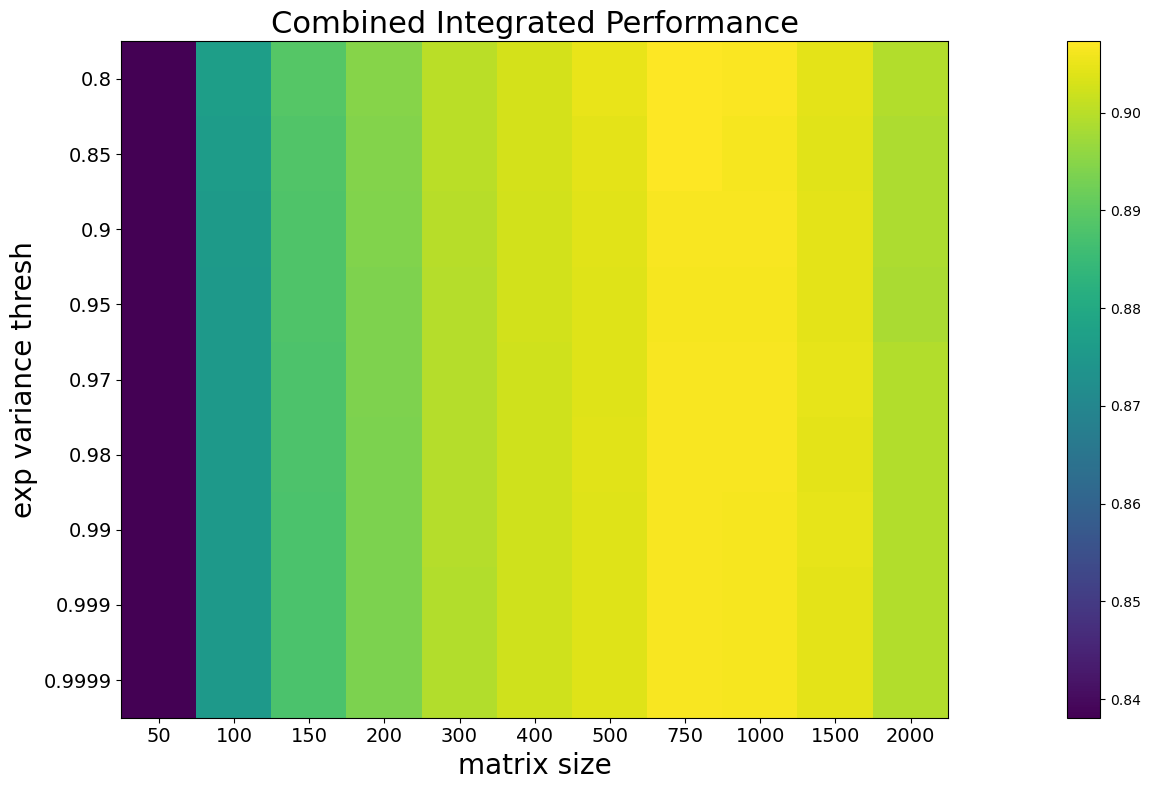

In [237]:
plt.figure(figsize=(24, 8))

norm = Normalize(vmin=ip_mean.min(),vmax=ip_mean.max())

plt.imshow(ip_mean.T, norm=norm)
plt.xticks(np.arange(len(matrix_size_vals)), [f"{matrix_size}" for matrix_size in matrix_size_vals])
plt.xlabel("matrix size", fontsize=20)
plt.yticks(np.arange(len(exp_variance_thresh_vals)), [f"{exp_variance_thresh}" for exp_variance_thresh in exp_variance_thresh_vals])
plt.ylabel('exp variance thresh', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=14)
ax.set_title('Combined Integrated Performance', fontsize=22)
plt.colorbar(ax=ax)

plt.tight_layout()
plt.show()

In [238]:
max_lyaps = [lyaps[key][0] for key in keys[key_inds]]

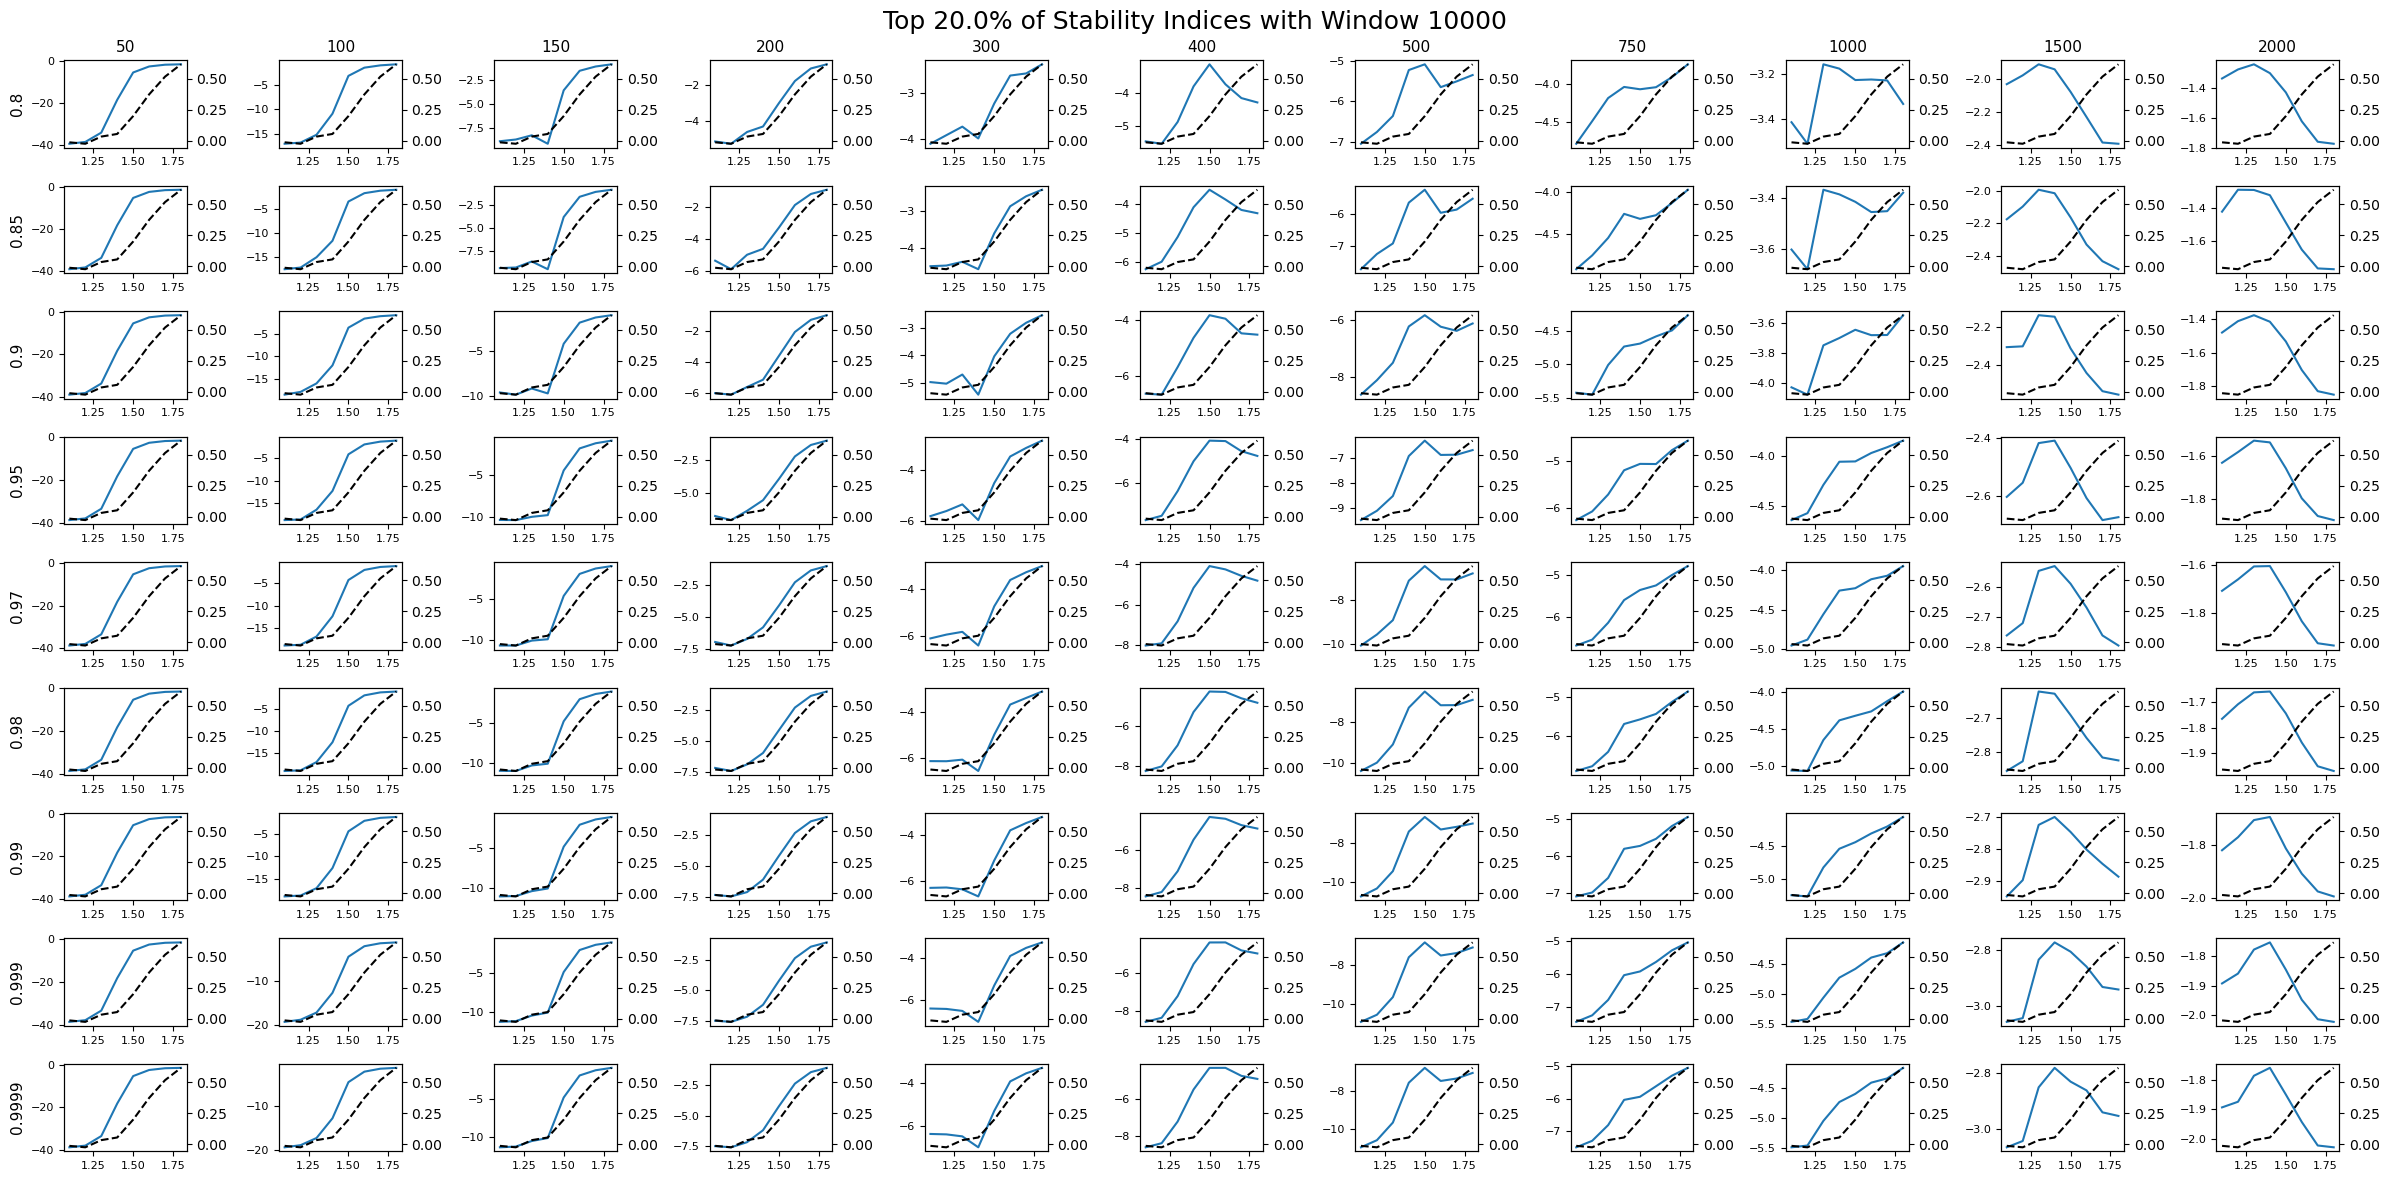

In [239]:
fig, axs = plt.subplots(len(exp_variance_thresh_vals), len(matrix_size_vals), figsize=(24, 12))
for i, exp_variance_thresh in enumerate(exp_variance_thresh_vals):
    for j, matrix_size in enumerate(matrix_size_vals):
        ax = axs[i][j]
        ax.plot(keys[key_inds], stab_curve[(matrix_size, exp_variance_thresh)][key_inds])
        ax2 = ax.twinx()
        ax2.plot(keys[key_inds], max_lyaps, linestyle='--', c='k')
        if i == 0:
            ax.set_title(f'{matrix_size}', fontsize=11)
        if j == 0:
            ax.set_ylabel(f'{exp_variance_thresh}', fontsize=11)
        ax.tick_params(labelsize=8)
plt.suptitle(f'Top {top_percent*100}% of Stability Indices with Window {window}', fontsize=18)
plt.tight_layout()
plt.show()

# FNN Method

In [262]:
m_vals = np.array([int(np.ceil(matrix_size/50)) for matrix_size in matrix_size_vals])
# m_vals = np.hstack([1, m_vals])
# m_vals = np.arange(10) + 1
fraction_fnn = np.zeros(m_vals.shape)

In [263]:
m_vals

array([ 1,  2,  3,  4,  6,  8, 10, 15, 20, 30, 40])

In [264]:
m_vals = m_vals[:-3]

In [265]:
m_vals

array([ 1,  2,  3,  4,  6,  8, 10, 15])

In [266]:
num_samples = 1000
time_step_bound = 10
r=1.01
p = 2
iterator = tqdm(total=len(key_inds)*len(m_vals))
ratio_arrays_all = np.zeros((len(key_inds), len(m_vals), num_samples))
for i, key in enumerate(keys[key_inds]):
    signal = signals[key]
    
    fnn_stats = []
    ratio_arrays = []
    for j, m in enumerate(m_vals):
        embedding = embed_signal((signal - signal.mean())/signal.std(), m, tau=1)
        sample_indices = np.random.choice(np.arange(embedding.shape[0]), size=(num_samples, ), replace=False)
        nn_indices, _, sample_indices = get_nn_indices(embedding, time_step_bound, sample_indices, p=p)
        fraction_greater, ratios = calculate_fnn_stat(embedding, nn_indices, r, sample_indices=sample_indices, p=p, verbose=False)
#         fnn_stats.append(fraction_greater)
#         ratio_arrays.append(ratios)
        ratio_arrays_all[i, j] = ratios
        
        iterator.update()
    
#     min_length = np.min([len(ratio) for ratio in ratio_arrays])
#     ratio_arrays = np.array([ratio[:min_length] for ratio in ratio_arrays])

  0%|          | 0/96 [00:00<?, ?it/s]

In [275]:
num_r_vals = 100
fnn_curves = np.zeros((num_r_vals, ratio_arrays_all.shape[1]))
r_vals = np.linspace(ratio_arrays_all.min(), ratio_arrays_all.max(), num_r_vals)
for i, r in enumerate(r_vals):
    fnn_curves[i] = (ratio_arrays_all > r).sum(axis=(0, 2))/(ratio_arrays_all.shape[0]*ratio_arrays_all.shape[2])

In [ ]:
1.08202907

In [290]:
((ratio_arrays_all > 1.0616).sum(axis=(0, 2))/(ratio_arrays_all.shape[0]*ratio_arrays_all.shape[2])).astype(float)

array([4.93416667e-01, 3.03333333e-01, 1.69750000e-01, 8.73333333e-02,
       1.68333333e-02, 1.75000000e-03, 1.66666667e-04, 0.00000000e+00])

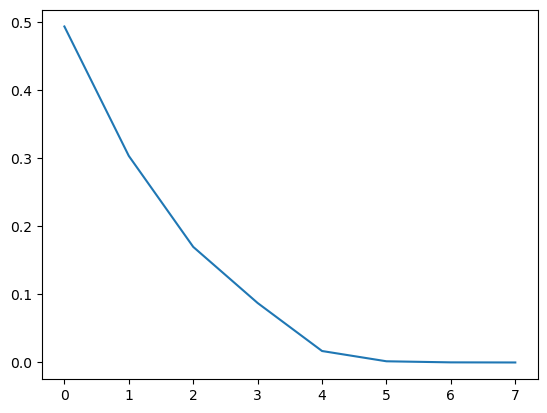

In [287]:
plt.plot((ratio_arrays_all > 1.0616).sum(axis=(0, 2))/(ratio_arrays_all.shape[0]*ratio_arrays_all.shape[2]))

In [ ]:
plt.

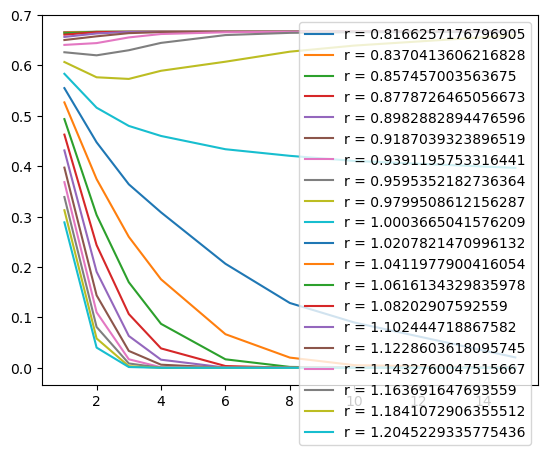

In [285]:
for i in range(40, 60):
    plt.plot(m_vals, fnn_curves[i], label=f'r = {r_vals[i]}')
plt.legend()

# Checking

In [113]:
results_2 = []
# iterator = tqdm(total=len(parameter_grid.window_vals)*len(parameter_grid.matrix_size_vals)*len(exp_variance_vals))
iterator = tqdm(total=len(signals)*2)
for window in [5000]:
    for matrix_size in [550]:
        delases = []
        exp_variances = []
        test_signals = []
        for key, signal in signals.items():
            train_signal = signal[transient:transient + window]
            test_signal = signal[transient + window:transient + window + prediction_time]
            delase = DeLASE(train_signal, matrix_size=matrix_size, dt=dt, use_torch=True, device='cuda')
#        
#             exp_variances.append(compute_explained_variance(delase.S.cpu()))
            delases.append(delase)
#             test_signals.append(test_signal)
            iterator.update()
            
#         for thresh in exp_variance_vals:
#             r = np.max([int(np.argmax(exp_variance > thresh)) for exp_variance in exp_variances])
        for r in [75]:
            ips = []
            stab_curves = []
            for i, delase in enumerate(delases):
                delase.compute_havok_dmd(r=r)
                delase.get_stability(max_freq=500, max_unstable_freq=125)
            
#                 ip = compute_integrated_performance(delase, test_signals[i], full_return=True)
                
#                 ips.append(ip)
                stab_curves.append(delase.stability_params.cpu())
    
                iterator.update()
            
            results_2.append(dict(
                window=window,
                matrix_size=matrix_size,
                exp_variances=exp_variances,
                exp_variance_thresh=thresh,
                r=r,
                ips=ips,
                stab_curves=stab_curves,
            ))
            
                
iterator.close()

  0%|          | 0/24 [00:00<?, ?it/s]

In [116]:
top_percent = 0.2

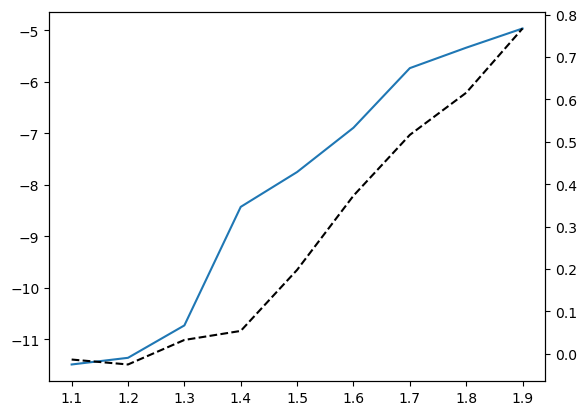

In [117]:
plt.plot(keys[key_inds], np.array([curve[:int(top_percent*len(curve))].mean() for curve in results_2[0]['stab_curves']])[key_inds])
ax2 = plt.gca().twinx()
ax2.plot(keys[key_inds], max_lyaps, linestyle='--', c='k')
plt.show()